#### Import necessary libraries

In [353]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
from seaborn import heatmap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score

#### Load the Dataset

In [354]:
DATASET_DIRECTORY = "./Datasets/"
DATASET_FILE_NAME = "diabetes.csv"
df = pd.read_csv(DATASET_DIRECTORY + DATASET_FILE_NAME)
TARGET = "Outcome"
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

First of all, let's analyse the dataset using pandas methods.
1. DataFrame.info: Shows the type and number of non-NAN values for each column.
- 8 features in teh dataset.
- Not even a single missing value.

In [355]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


2. DataFrame.head/tail: Shows n first/last rwos of the dataframe

In [356]:
numof_rows_to_display = 4
pd.concat([df.head(n=numof_rows_to_display), df.tail(n=numof_rows_to_display)])

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


3. DataFrame.describe: summarizes each numerical column using statistical metrics.

In [357]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### Checking for possible noisy or missing data
First we'll check values of features one by one.
- 374 samples have zero Insulin.
- 227 samples have zero SkinThickness.
- 11 samples have zero BMI.
These records are a sign of noisy data. some possible explanations could be:
1. `Measurement Limitations`: In some cases, the measured feature level might be below the detection limit, resulting in a recorded value of zero.
2. `Data Entry Practices`: Sometimes, missing or unrecorded values are entered as zero.

But how to handle them?
1. drop the entire column.
2. drop a limited number of rows.

In [358]:
for col in ["Insulin", "SkinThickness", "BMI", "Glucose", "BloodPressure"]:
    print(f"{len(df[(df[col] == 0)])} missing {col} values.")

374 missing Insulin values.
227 missing SkinThickness values.
11 missing BMI values.
5 missing Glucose values.
35 missing BloodPressure values.


Number of missing values in `BMI`, `Glucose` and `BloodPressure` are very few. By droping these rows we won't lose much data.

In [359]:
df = df[(df["BMI"] > 0) & (df["Glucose"] > 0) & (df["BloodPressure"] > 0)]

But if we remove the rows containing missing value of `Insulin` or `SkinThickness`, About half of the dataset would be gone. We have two options:
1. Droping the entire column
2. imputing the missing values using existing ones.

Here we put the missing values aside andthe calculate the feature's correlation with other columns. It shows that both of them have a good correlation with the target.


In [360]:
for col in ["Insulin", "SkinThickness"]:
    print("Correlation of each column with", col)
    print(df[df[col] != 0].corr(method="pearson")[col].sort_values(ascending=False))
    print()

Correlation of each column with Insulin
Insulin                     1.000000
Glucose                     0.581223
Outcome                     0.301429
BMI                         0.226397
Age                         0.217082
SkinThickness               0.182199
DiabetesPedigreeFunction    0.135906
BloodPressure               0.098512
Pregnancies                 0.078984
Name: Insulin, dtype: float64

Correlation of each column with SkinThickness
SkinThickness               1.000000
BMI                         0.647422
Outcome                     0.254874
Glucose                     0.226590
BloodPressure               0.226072
Age                         0.161336
Insulin                     0.126240
DiabetesPedigreeFunction    0.118636
Pregnancies                 0.095085
Name: SkinThickness, dtype: float64



By looking at the distribution of non-missing values we understand that Both `Insulin` and `SkinThickness` aew right skewed.

In [361]:
cols = ["Insulin", "SkinThickness"]
fig = make_subplots(cols=2, rows=1, subplot_titles=cols)
for i in range(len(cols)):
    fig.add_trace(px.histogram(data_frame=df[df[cols[i]] != 0], x=cols[i], nbins=100).data[0], row=1, col=i+1)
fig.show()

How to fill `Insulin` and `SkinThickness`?
- Mode: It's not the right way to fill a continuous variable.
- Mean: The right-skewness affects on the mean.
- Median: It won't be affected be the skewness of the distribtion.

In [362]:
cols = ["Insulin", "SkinThickness"]
for col in cols:
    non_zero_median = df[df[col] > 0][col].median()
    df[col] = df[col].replace(to_replace=0, value=non_zero_median)

#### Checking for duplicate data

In [363]:
def report_duplicate_data(df):
    duplicated = df[df.duplicated()]
    if (len(duplicated)):
        print("There are", len(duplicated), "duplicated entries in the dataset")
        return duplicated
    else:
        print("No duplicate data")
        return None
report_duplicate_data(df=df)

No duplicate data


## Feature Selection

Here is a list of reasons why sould we drop a feature:
- Weakly correlated with the target.
- High amount of missing/noisy/outlier data.
- If two or more features are highly correlated, they can cause redundancy.
- Features with little variation don’t contribute much to the predictive power and can be removed.

We will use below metrics to detect important features and drop teh others.

#### Spearman Rank Correlation
Similar to Pearson, but applicable to ordinal or non-linear relationships. It ranks the data before computing the correlation.
$$ \rho_s = 1 - \frac{{6 \sum d_i2}}{{n(n2 - 1)}} $$

#### Point-Biserial Correlation Coefficient
This metric assesses the association between a continuous feature and a binary target variable.

It quantifies how much the mean of the feature differs between the two target classes (0 and 1).
$$ r_{pb} = \frac{{\bar{x}_1 - \bar{x}_0}}{{s}} \cdot \sqrt{\frac{{n_0 \cdot n_1}}{{n^2}}} $$
where:

$ \bar{x}_1 $ and $ \bar{x}_0 $ are the means of the feature for target classes 1 and 0, respectively.

$ s $ is the standard deviation of the feature.

$ n_0 $ and $ n_1 $ are the sample sizes for target classes 0 and 1, respectively.

$ n $ is the total sample size.

#### Effect Size (Cohen's d)
Cohen's d measures the standardized difference in means between the two target classes.

It provides insight into the practical significance of the feature’s effect.
$$ d = \frac{{\bar{x}_1 - \bar{x}_0}}{{s}} $$

where:

$ \bar{x}_1 $ and $ \bar{x}_0 $ are the means of the feature for target classes 1 and 0, respectively.

$ s $ is the pooled standard deviation of the feature.

#### Kruskal-Wallis H Test (for non-parametric data):
It assesses whether the feature's distribution differs significantly across the two target classes.

The null hypothesis is that the distributions are the same.

If the p-value is small (typically less than 0.05), reject the null hypothesis, indicating significant differences among groups.

Features with small p-values (indicating significant differences) are potentially good discriminators.

### Summary
Good discriminator features:
- High pearson, spearman, kendall, mutual information, point biserial, Cohen's D
- Low Kruskal

In [364]:
import pandas as pd
from scipy.stats import pointbiserialr, kruskal, f_oneway
from sklearn.feature_selection import mutual_info_classif

def calc_point_biserial(df_feat, df_targ):
    r_pb, _ = pointbiserialr(df_feat, df_targ)
    return r_pb

def calc_cohen_d(df_feat_targ, targ, feat):
    x1 = df_feat_targ[df_feat_targ[targ] == 1][feat]
    x0 = df_feat_targ[df_feat_targ[targ] == 0][feat]
    n1, n0 = len(x1), len(x0)
    s_pooled = ((n1 - 1) * x1.std()**2 + (n0 - 1) * x0.std()**2) / (n1 + n0 - 2)
    return (x1.mean() - x0.mean()) / (s_pooled**0.5)

def calc_kruskal(df_feat_targ, targ, feat):
    x1 = df_feat_targ[df_feat_targ[targ] == 1][feat]
    x0 = df_feat_targ[df_feat_targ[targ] == 0][feat]
    _, p_value = kruskal(x1, x0)
    return p_value

In [365]:
def create_feature_evaluation_df(df, target):
    df_feat_eval = pd.DataFrame()
    df_feat_eval['feature'] = [col for col in df.columns if col != target]

    spearman_corr = df.corr(method='spearman')
    kendall_corr = df.corr(method='kendall')

    df_feat_eval["spearman corr"] = df_feat_eval["feature"].apply(lambda x: spearman_corr[target][x])
    df_feat_eval["kendall corr"] = df_feat_eval["feature"].apply(lambda x: kendall_corr[target][x])

    df_feat_eval["pnt bis"] = df_feat_eval["feature"].apply(lambda x: calc_point_biserial(df_feat=df[x], df_targ=df[target]))
    df_feat_eval["cohen d"] = df_feat_eval["feature"].apply(lambda x: calc_cohen_d(df_feat_targ=df[[target, x]], targ=target, feat=x))
    df_feat_eval["kruskal"] = df_feat_eval["feature"].apply(lambda x: calc_kruskal(df_feat_targ=df[[target, x]], targ=target, feat=x))

    return df_feat_eval

In [366]:
df_feat_eval = create_feature_evaluation_df(df, target=TARGET)
df_feat_eval

,feature,spearman corr,kendall corr,pnt bis,cohen d,kruskal
0,Pregnancies,0.205200,0.175944,0.224417,0.484137,3.437470e-08
1,Glucose,0.474320,0.389387,0.488384,1.176586,2.968368e-37
2,BloodPressure,0.174039,0.145306,0.166703,0.355431,2.873189e-06
3,SkinThickness,0.215470,0.183037,0.216357,0.465879,6.884869e-09
4,Insulin,0.279837,0.244807,0.211736,0.455455,5.294586e-14
5,BMI,0.295204,0.241803,0.299375,0.659625,2.060623e-15
6,DiabetesPedigreeFunction,0.182290,0.149034,0.184947,0.395637,9.509703e-07
7,Age,0.307456,0.255985,0.245741,0.532961,1.372681e-16


In [367]:
not_discriminator_features = df_feat_eval[df_feat_eval["kruskal"] > 0.05]["feature"].tolist()
not_correlated_features = df_feat_eval[(df_feat_eval["spearman corr"] < 0.2) & (df_feat_eval["kendall corr"] < 0.2)]["feature"].tolist()
not_different_in_mean_features = df_feat_eval[(df_feat_eval["pnt bis"] < 0.2) & (df_feat_eval["cohen d"] < 0.2)]["feature"].tolist() 
features_to_drop = np.unique(not_discriminator_features + not_correlated_features + not_different_in_mean_features)
features_to_drop

array(['BloodPressure', 'DiabetesPedigreeFunction'], dtype='<U24')

In [368]:
df.drop(features_to_drop, axis=1, inplace=True)

Now that we've droped some less important features, let's take a look at the correlation matrix.

<Axes: >

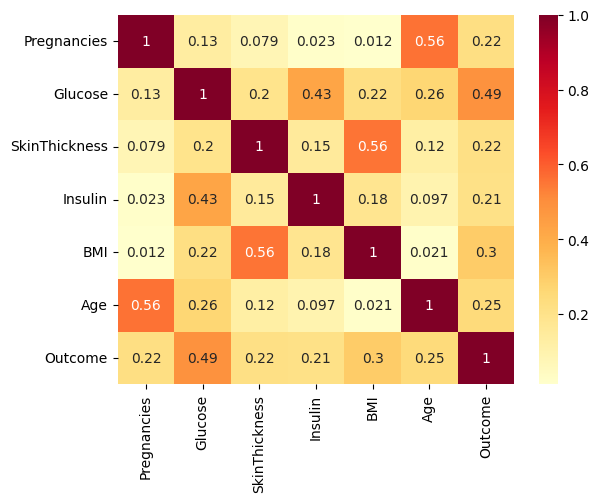

In [369]:
correlation_matrix = df.corr(method="pearson")
heatmap(correlation_matrix, annot=True, cmap="YlOrRd")

## Visualize Data

#### Pairplot
It shows that:
- all the features are well-distributed.
- None of the features can be replaced by any of the others. In other words each of them describe the target in a different way.  

In [370]:
num_cols = len(df.columns)
if num_cols % 2:
    fig = make_subplots(cols = 2, rows=num_cols//2, subplot_titles=[col for col in df.columns if col != TARGET])
    num_cols -= 1
else:
    fig = make_subplots(cols = 2, rows=num_cols//2, subplot_titles=[col for col in df.columns])
    
for i in range(0, num_cols, 2):
    fig.add_trace(px.histogram(data_frame=df, x=df.columns[i], nbins=20).data[0], row=i//2+1, col=1)    
    fig.add_trace(px.histogram(data_frame=df, x=df.columns[i+1], nbins=20).data[0], row=i//2+1, col=2)  

fig.update_layout(width=1250, height=800)
fig.show()

#### Violin Plot
It shows that:
- People with diabetes have higher `BMI`, `glucose level`, `number of pregnancies` and `Age` on average.
- Peope with diabetes have more centered `glucose level`, `number of pregnancies` and `DiabetesPedegreeFunction` around the median.

In [371]:
num_cols = len(df.columns)
if num_cols % 2:
    fig = make_subplots(cols = 2, rows=num_cols//2, subplot_titles=[col for col in df.columns if col != TARGET])
    num_cols -= 1
else:
    fig = make_subplots(cols = 2, rows=num_cols//2, subplot_titles=[col for col in df.columns])

for i in range(0, num_cols, 2):
    fig.add_trace(px.violin(data_frame=df, y=df.columns[i], x=TARGET, box=True).data[0], row=i//2+1, col=1)    
    fig.add_trace(px.violin(data_frame=df, y=df.columns[i+1], x=TARGET, box=True).data[0], row=i//2+1, col=2)  

fig.update_layout(width=1250, height=800)
fig.show()

### Split into train test

First we'll split the data into two dataframes (train and test)

In [372]:
train_size = 0.8
train_indices = np.random.choice(df.index, round(len(df) * train_size), replace=False)
df_train = df.loc[train_indices].reset_index(drop=True)
df_test = df.drop(train_indices).reset_index(drop=True)

No for eahc of the two dataframes, X and y matrixes are separated from each other.

In [373]:
features = [col for col in df_train.columns if col != TARGET]
X_train = df_train[features].to_numpy()
y_train = df_train[TARGET].to_numpy()
X_test = df_test[features].to_numpy()
y_test = df_test[TARGET].to_numpy()

### Train a model on raw data

In [374]:
LR_model = LogisticRegression(max_iter=100000)
LR_model.fit(X=X_train, y=y_train)

pred_train = LR_model.predict(X_train)
pred_test = LR_model.predict(X_test)

print("Accuracy of model on train set:", round(100 * precision_score(y_pred=pred_train, y_true=y_train), 2))
print("Accuracy of model on test set:", round(100 * precision_score(y_pred=pred_test, y_true=y_test), 2))

Accuracy of model on train set: 69.87
Accuracy of model on test set: 81.58


## Normalize data first

In [375]:
def normalize_data(x, min, max):
    if min == max:
        return x
    else:
        return  (x - min) / (max - min)

def standardize_data(x, mu, sigma):
    return (x - mu) / (sigma)

def denormalize_data(x, min, max):
    return ((x) * (max - min)) + min

def normal_data(method, df_train_org, df_test_org):
    df_train = df_train_org.copy()
    df_test = df_test_org.copy()
    for col in df.columns:
        if col == TARGET:
            continue

        if method == "normal":
            min = df_train[col].min()
            max = df_train[col].max()
            df_train[col] = normalize_data(df_train[col], min=min, max=max)
            df_test[col] = normalize_data(df_test[col], min=min, max=max)
        
        elif method == "standard":
            mu = df_train[col].mean()
            sigma = df_train[col].std()
            df_train[col] = standardize_data(df_train[col], mu=mu, sigma=sigma)
            df_test[col] = standardize_data(df_test[col], mu=mu, sigma=sigma)

        else:
            print("Not a valid method. Please choose between <normal> and <standard>")
    
    return df_train, df_test

df_train_norm, df_test_norm = normal_data(method="normal", df_train_org=df_train, df_test_org=df_test)
df_train_stan, df_test_stan = normal_data(method="standard", df_train_org=df_train, df_test_org=df_test)

features = [col for col in df.columns if col != TARGET]
X_train_norm = df_train_norm[features].to_numpy()
y_train_norm = df_train_norm[TARGET].to_numpy()
X_test_norm = df_test_norm[features].to_numpy()
y_test_norm = df_test_norm[TARGET].to_numpy()

X_train_stan = df_train_stan[features].to_numpy()
y_train_stan = df_train_stan[TARGET].to_numpy()
X_test_stan = df_test_stan[features].to_numpy()
y_test_stan = df_test_stan[TARGET].to_numpy()

### Train a model on normalized/standardized data

In [376]:
LR_model_norm = LogisticRegression(max_iter=100000)
LR_model_norm.fit(X=X_train_norm, y=y_train_norm)

LR_model_stan = LogisticRegression(max_iter=100000)
LR_model_stan.fit(X=X_train_stan, y=y_train_stan)

pred_train_norm = LR_model_norm.predict(X_train_norm)
pred_test_norm = LR_model_norm.predict(X_test_norm)
pred_train_stan = LR_model_stan.predict(X_train_stan)
pred_test_stan = LR_model_stan.predict(X_test_stan)

print("Accuracy of model on normalized train set:", round(100 * precision_score(y_pred=pred_train_norm, y_true=y_train_norm), 2))
print("Accuracy of model on normalized test set:", round(100 * precision_score(y_pred=pred_test_norm, y_true=y_test_norm), 2))
print("Accuracy of model on standardized train set:", round(100 * precision_score(y_pred=pred_train_stan, y_true=y_train_norm), 2))
print("Accuracy of model on standardized test set:", round(100 * precision_score(y_pred=pred_test_stan, y_true=y_test_norm), 2))

Accuracy of model on normalized train set: 70.42
Accuracy of model on normalized test set: 83.33
Accuracy of model on standardized train set: 69.87
Accuracy of model on standardized test set: 81.58


## Feature Engineering

In [377]:
def put_label(x, bins):
    for i in range(len(bins) - 1):
        if (x >= bins[i] and x <= bins[i+1]):
            return i + 1

df['BMI cat'] = df["BMI"].apply(lambda x: int(put_label(x=x, bins=[0, 18.5, 24.9, 29.9, 100])))
df['Age cat'] = df["Age"].apply(lambda x: int(put_label(x=x, bins=[0, 18, 30, 50, 100])))
df.drop(["BMI", "Age"], axis=1, inplace=True)

### Train a model after adding features but without any normalization

In [378]:
df_train = df.loc[train_indices].reset_index(drop=True)
df_test = df.drop(train_indices).reset_index(drop=True)

features = [col for col in df_train.columns if col != TARGET]
X_train = df_train[features].to_numpy()
y_train = df_train[TARGET].to_numpy()
X_test = df_test[features].to_numpy()
y_test = df_test[TARGET].to_numpy()

LR_model = LogisticRegression(max_iter=100000)
LR_model.fit(X=X_train, y=y_train)

pred_train = LR_model.predict(X_train)
pred_test = LR_model.predict(X_test)

print("Accuracy of model on train set (with some added features):", round(100 * precision_score(y_pred=pred_train, y_true=y_train), 2))
print("Accuracy of model on test set (with some added features):", round(100 * precision_score(y_pred=pred_test, y_true=y_test), 2))

Accuracy of model on train set (with some added features): 66.67
Accuracy of model on test set (with some added features): 82.93


### Train a model after adding features and normalizing data

In [379]:
df_train_norm, df_test_norm = normal_data(method="normal", df_train_org=df_train, df_test_org=df_test)
df_train_stan, df_test_stan = normal_data(method="standard", df_train_org=df_train, df_test_org=df_test)

features = [col for col in df.columns if col != TARGET]
X_train_norm = df_train_norm[features].to_numpy()
y_train_norm = df_train_norm[TARGET].to_numpy()
X_test_norm = df_test_norm[features].to_numpy()
y_test_norm = df_test_norm[TARGET].to_numpy()

X_train_stan = df_train_stan[features].to_numpy()
y_train_stan = df_train_stan[TARGET].to_numpy()
X_test_stan = df_test_stan[features].to_numpy()
y_test_stan = df_test_stan[TARGET].to_numpy()

In [380]:
LR_model_norm = LogisticRegression(max_iter=100000)
LR_model_norm.fit(X=X_train_norm, y=y_train_norm)

LR_model_stan = LogisticRegression(max_iter=100000)
LR_model_stan.fit(X=X_train_stan, y=y_train_stan)

pred_train_norm = LR_model_norm.predict(X_train_norm)
pred_test_norm = LR_model_norm.predict(X_test_norm)
pred_train_stan = LR_model_stan.predict(X_train_stan)
pred_test_stan = LR_model_stan.predict(X_test_stan)

print("Accuracy of model on normalized train set:", round(100 * precision_score(y_pred=pred_train_norm, y_true=y_train_norm), 2))
print("Accuracy of model on normalized test set:", round(100 * precision_score(y_pred=pred_test_norm, y_true=y_test_norm), 2))
print("Accuracy of model on standardized train set:", round(100 * precision_score(y_pred=pred_train_stan, y_true=y_train_norm), 2))
print("Accuracy of model on standardized test set:", round(100 * precision_score(y_pred=pred_test_stan, y_true=y_test_norm), 2))

Accuracy of model on normalized train set: 67.86
Accuracy of model on normalized test set: 82.05
Accuracy of model on standardized train set: 67.11
Accuracy of model on standardized test set: 82.93


In [381]:
def plot_confusion_matrix(y_true, y_pred):
    conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
    heatmap(conf_mat, annot=True, cmap="YlOrRd")

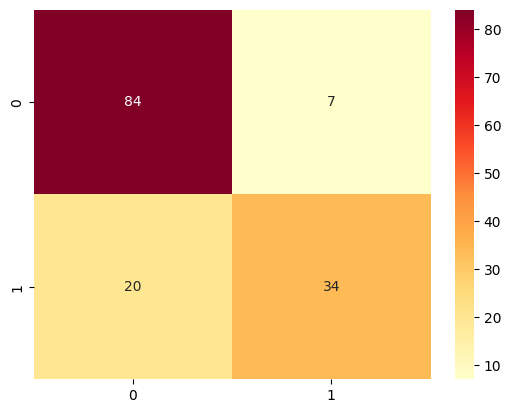

In [382]:
plot_confusion_matrix(y_true=y_test, y_pred=pred_test)

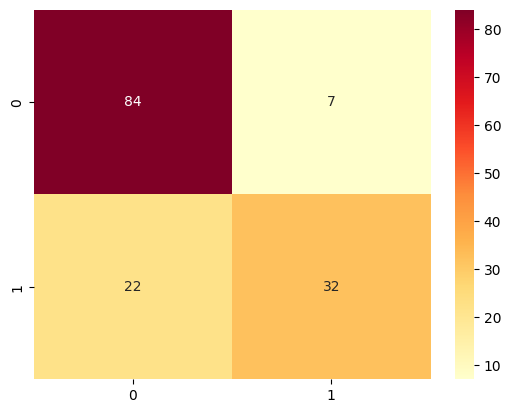

In [383]:
plot_confusion_matrix(y_true=y_test_norm, y_pred=pred_test_norm)

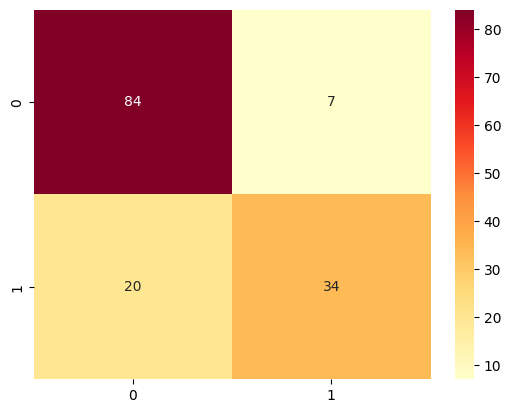

In [384]:
plot_confusion_matrix(y_true=y_test_stan, y_pred=pred_test_stan)